## Ablation study

If a group of filters are almost identical in the cosine-similarity sense, then can we replace that group by a single filter? And how does this affect the network outputs?




### Filter similarity matrix

We load in a pre-trained network (see the Notebook `run_cifar_train_mlp`) and compute the simlarity matrix of its first layer "filters" -- for a fully-connected network this would correspond to the 3072-dimensional column-vectors of the weight matrix of the first layer.

In [1]:
# setup
import os
import torch
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# local utils
# !find . -name \*.pyc -delete
from vis_utils import *
from model_def import *
from model_train import *

%matplotlib inline


expName = 'cifar-MLP_v6.0.5' # pre-trained MLP - w1:500, w2:100
batchSize = 100

# create experiment folder
expDir = os.path.join('./data', expName)
if not os.path.exists(expDir):
    os.makedirs(expDir)
    
# setup and load CIFAR dataset
trainloader, testloader, classes = setup_cifar_data_mlp(batchSize)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
def get_dataset_loss(net, dataloader, criterion = nn.CrossEntropyLoss()):
    '''
        Calculate the network loss over a dataset.
        Returns a vector containing the loss for every data point.
    '''
    
    data_loss = []    
    useGpu = next(net.parameters()).is_cuda
    
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        if useGpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels)  
        data_loss.append(loss.data.cpu())
        
    data_loss = [x.numpy()[0] for x in data_loss]    
    return data_loss

In [72]:
# create the fully-connected network with ReLU non-linearities
net = MLP(input_dim=3072, fc1_dim=500, fc2_dim=100)

# Load trained MLP model and look at closest pairs of filters
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

net.cpu()

MLP (
  (fc1): Linear (3072 -> 500)
  (fc2): Linear (500 -> 100)
  (fc3): Linear (100 -> 10)
)

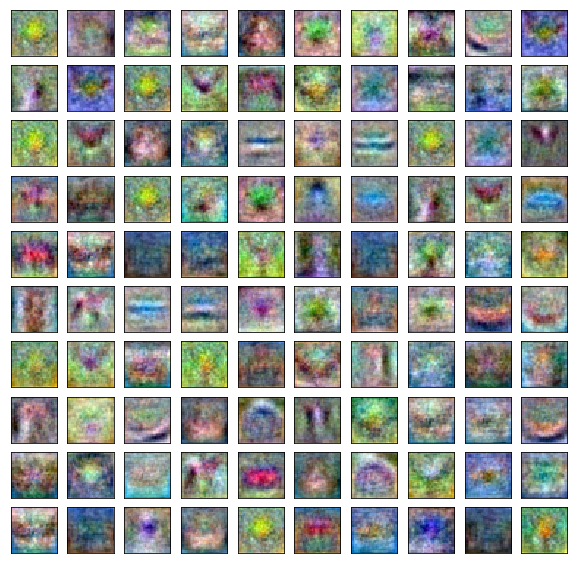

In [4]:
# Get similarity matrix and show top-K pairs
similMat, w = get_layer_cosine_similarity(net.cpu(), 'fc1.weight')
MAX_PAIRS = 10
outDir = expDir

# show the filter pairs
# _, pairList = vis_closest_filter_pairs(w, similMat, MAX_PAIRS)       

f = vis_linear_weights(w)


In [117]:
# evaluate the original network
# -- should be 53%
net.eval()
orig_accu = accuracy_on_dataset(net, testloader, True)
print 'Original network accuracy: %.2f' % orig_accu

orig_data_loss = get_dataset_loss(net, testloader)
print 'Original network data loss: %.4f' % np.mean(orig_data_loss)

Original network accuracy: 53.00
Original network data loss: 1.3616


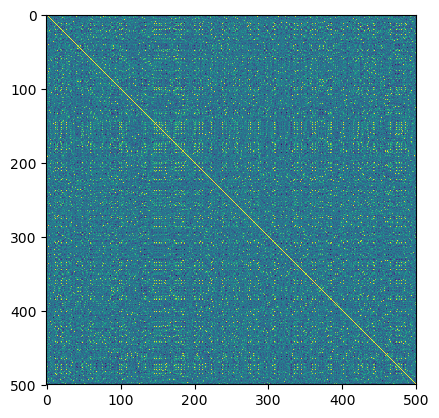

In [118]:
f = plt.figure()
plt.imshow(similMat) # show similarity matrix
plt.savefig(os.path.join(expDir,'mlp-w1-simil.png'), bbox_inches='tight')

### Connected components of similar filters




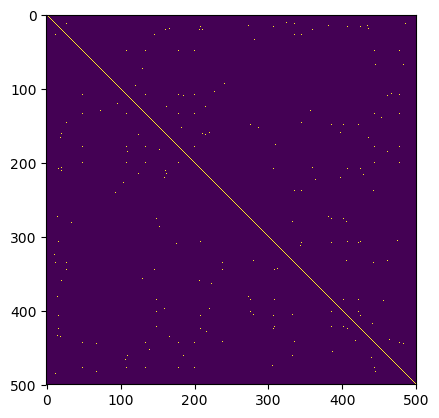

In [119]:
# Get an adjancency matrix by thresholding the similarity matrix
SIMIL_THRESH = 0.98
sz = similMat.shape
adj_mat = np.greater(similMat, SIMIL_THRESH)

f = plt.figure()
plt.imshow(adj_mat)  # show adjacency matrix
plt.savefig(os.path.join(expDir,'mlp-w1-adj-mat-%.2f.png' % SIMIL_THRESH), bbox_inches='tight')

In [8]:
# Find connected components in the graph induced by the adjacency matrix
from scipy.sparse import *
n_comps, comp_labels = csgraph.connected_components(adj_mat, directed=False)
cc_set = np.unique(comp_labels)

In [9]:

# init a list of lists
cc_list = []
for i in range(len(cc_set)):
    cc_list.append([])

# cc_list[i] stores the indices (j) of the filters in the i-th conn-comp
for i in range(len(cc_set)):
    for j in range(sz[0]):
        if comp_labels[j] == cc_set[i]:
            cc_list[i].append(j)


In [10]:
# Group the filters in each connected component (cc)
outDir = os.path.join(expDir, ('filter_ccomp_%.2f' % SIMIL_THRESH))
if not os.path.exists(outDir):
    os.makedirs(outDir)
    
# Get the filters in a CPU numpy array    
fc1_weights = net.fc1.weight.data.cpu()
fc1_weights = fc1_weights.numpy()

# Get the bias values for each filter
fc1_biases = net.fc1.bias.data.cpu()
fc1_biases = fc1_biases.numpy()

bias_val = [fc1_biases[x] for x in cc_list]


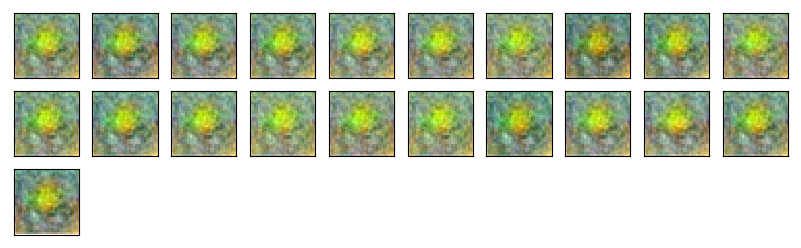

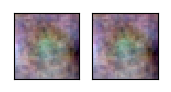

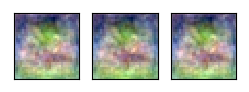

In [11]:
# Some sanity-checks: visualize some of the filter groups
f = vis_linear_weights(fc1_weights[cc_list[0]]) 
f = vis_linear_weights(fc1_weights[cc_list[1]])
f = vis_linear_weights(fc1_weights[cc_list[2]]) 

In [12]:
# Print out the biases for those same filter groups
print fc1_biases[cc_list[0]]
print fc1_biases[cc_list[1]]
print fc1_biases[cc_list[2]]

[ 0.01790267  0.06339222  0.01225822  0.01943754  0.01694     0.0087124
  0.02052768  0.00977978  0.00900509  0.02609462  0.0275471   0.02839933
  0.02669318  0.01464979  0.01108932  0.00769131  0.00802891  0.02085854
  0.00834615  0.01784183  0.01147795]
[ 0.01260188  0.0092797 ]
[ 0.00225052  0.00770126  0.01382509]


In [13]:
# Print out the norms of the filters in the filter groups
print [ np.linalg.norm(w) for w in fc1_weights[cc_list[0]] ]
print [ np.linalg.norm(w) for w in fc1_weights[cc_list[1]] ]
print [ np.linalg.norm(w) for w in fc1_weights[cc_list[2]] ]

[0.045579161, 0.18611306, 0.032723535, 0.048916616, 0.044610474, 0.023154335, 0.049587313, 0.02920825, 0.023913147, 0.06488324, 0.066258013, 0.075001858, 0.067560554, 0.034925897, 0.02714261, 0.018804545, 0.021381082, 0.054155864, 0.025560828, 0.045993179, 0.034088094]
[0.12358262, 0.10077423]
[0.021809677, 0.072956905, 0.13872513]


KeyboardInterrupt: 

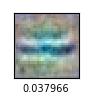

In [15]:
# Plot the filters in each filter group and save the figures to file
w = fc1_weights
for i in range(len(cc_list)):
        
    plt.rcParams["figure.figsize"] = (10, 10) # (width, height)
    f = plt.figure()
    subplotCounter = 1
    
    K = np.min([len(cc_list[i]), 100])
    
    # plot the filters in each filter conn_comp
    for j in range(K):
        w1 = w[cc_list[i][j]]
        w1 = w1.reshape(3, 32, 32)
        w1 = np.transpose(w1, (1,2,0))
        low, high = np.min(w1), np.max(w1)
        im1 = 255.0 * (w1 - low) / (high - low)
        
        ax = f.add_subplot(10, 10, subplotCounter)
        ax.imshow(im1.astype('uint8'))
        subplotCounter += 1
        ax.set_xticks([]); ax.set_yticks([]); ax.set_xticklabels([]); ax.set_yticklabels([])
        ax.set_xlabel('%.6f' % bias_val[i][j], fontsize=7)
     
    f.savefig(os.path.join(outDir, ('%d-1.png' % i)), \
             bbox_inches='tight')
    plt.close(f)
    plt.rcParams.update(plt.rcParamsDefault)

#### Distribution of filter group sizes

We observe that very large filter groups are not common -- most connected components being of sizes between 1 to 4. There are a few large groups of redundant filters. A component of size one would be a singleton filter group that is sufficiently dissimilar to all other filters in its layer.

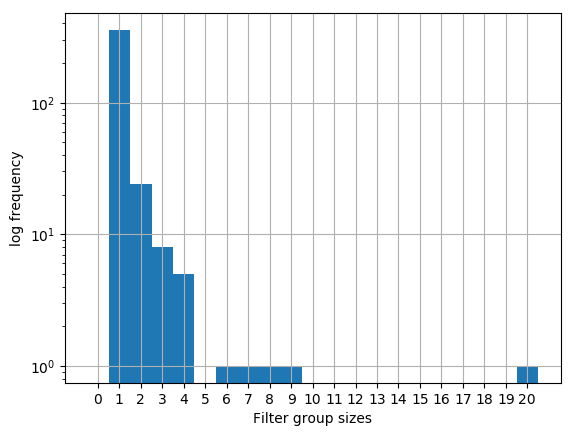

In [120]:
# Distribution of filter-cc sizes
cc_sizes = [len(x) for x in cc_list]
f = plt.figure()
plt.rcParams.update(plt.rcParamsDefault)
plt.hist(cc_sizes, bins=range(np.max(cc_sizes)+1), align='left', log=True);
plt.xticks(range(np.max(cc_sizes)));
plt.grid(); plt.xlabel('Filter group sizes'); plt.ylabel('log frequency')
f.savefig(os.path.join(expDir, 'filter-group-size-hist_%.2f.png' % SIMIL_THRESH), \
          bbox_inches='tight')

#### Norms of weights in a filter group

The filters in a connected component or "filter group" are similar based on the cosine of the angles between their weight vectors. Although they may be pointing in the same _direction_, their _lengths_ may be different. This is indeed the case, as the norms of the filters within a group end up being quite different. The fact also makes the cosine similarity a better metric for filter similarity than L2-distance.

Standard Deviation of weight norms within non-singleton filter groups:


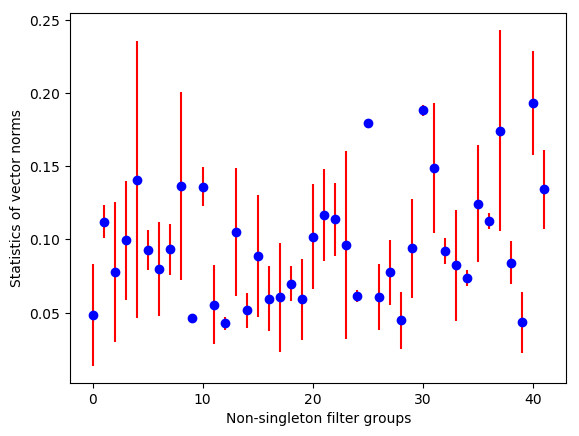

In [122]:
# The norms of each weight in a filter group
group_w_norms = [ [np.linalg.norm(w) for w in fc1_weights[x]] for x in cc_list ]
w_norm_std = np.asarray([np.std(x) for x in group_w_norms])
w_norm_mean = np.asarray([np.mean(x) for x in group_w_norms])
group_non_singleton = np.where([(len(x)>1) for x in cc_list])
w_norm_std = w_norm_std[group_non_singleton]
w_norm_mean = w_norm_mean[group_non_singleton]

print 'Standard Deviation of weight norms within non-singleton filter groups:'
f = plt.figure()
plt.rcParams.update(plt.rcParamsDefault)
plt.errorbar(range(len(w_norm_mean)), w_norm_mean, yerr=w_norm_std, fmt='bo', ecolor='r')
plt.ylabel('Statistics of vector norms')
plt.xlabel('Non-singleton filter groups')
f.savefig(os.path.join(expDir, 'filter-group-norm-stats-%.2f.png' % SIMIL_THRESH), \
          bbox_inches='tight')


### Connection sparsity structure

Visualize the connection matrix from the first layer to the second -- the fc2 weights.




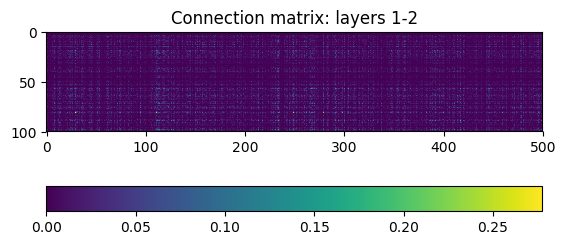

In [123]:
# plot the fc-2 weight matrix
net.cpu()
w_fc2 = np.abs(net.fc2.weight.data.numpy())  # absval
plt.imshow(w_fc2)
plt.title('Connection matrix: layers 1-2')
plt.colorbar(orientation='horizontal')

0.277616
3.33917e-12


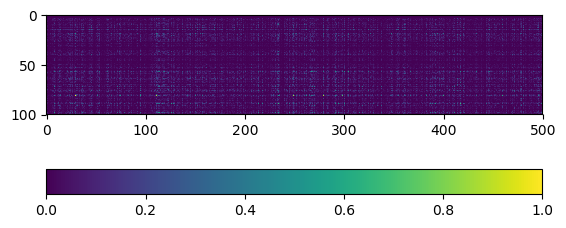

In [124]:
# connection scales for the whole layer
w_fc2_min = np.min(np.abs(w_fc2))
w_fc2_max = np.max(np.abs(w_fc2))

print np.max(np.abs(w_fc2))
print np.min(np.abs(w_fc2))

plt.imshow(w_fc2/w_fc2_max)
plt.colorbar(orientation='horizontal')

In [ ]:
# visualize connection matrices for some filter groups






In [ ]:
# Summary stats of L1-norms of all non-singleton filter groups





### Equivalence-preserving weight normalization

We normalize each *fc1* layer filter (a row of first layer weight matrix *W*) by its L2-norm and then scale the corresponding connections to the fc2 layer (a column of second layer weight matrix *V*).

Let us assume a non-linearity of the form $$ \phi(a \mathbf x) = a \phi(\mathbf x) $$
This holds true for the commonly used ReLU activation function in the positive domain.

Then, for one row of the first layer's weight matrix and bias term and _one_ connection to the next layer, we have,

$$ y_1 = v_1 . \phi(\mathbf{w}_1 \mathbf x + b_1) 
       = v_1 . \phi(||\mathbf{w}_1|| \frac{\mathbf{w}_1}{||\mathbf{w}_1||} \mathbf x + ||\mathbf{w}_1|| \frac{b_1}{||\mathbf{w}_1||}) 
       = ||\mathbf{w}_1|| . v_1 . \phi(\tilde{\mathbf{w}}_1 \mathbf x + \tilde b_1) $$


This normalization of fc1 weights should keep the function computed by the network exactly the same as before.

In [18]:
# Unchanged network
net = MLP(input_dim=3072, fc1_dim=500, fc2_dim=100)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
net.cpu()
orig_data_loss = get_dataset_loss(net, testloader)
np.mean(orig_data_loss)


1.3616375

#### Parameter scaling

In [19]:
# Scale the fc1 filter weights and the biases by the inverse of the filter norms
w_n = [torch.norm(w,p=2) for w in net.fc1.weight] 
w_normed = [w.div(w_n[index]) for index, w in enumerate(net.fc1.weight)] 
w_normed = torch.stack(w_normed, dim=0)
b_normed = torch.stack([b.div(w_n[index]) for index, b in enumerate(net.fc1.bias)]).squeeze()

print type(w_normed) 
print type(b_normed)

<class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'>


In [20]:
# Scale the fc2 weight columns to account for the changed fc1 layer parameter values
fc2_sc = []
for i in range(net.fc2.weight.size()[1]):
    fc2_sc.append( net.fc2.weight[:,i] * w_n[i] )
fc2_sc = torch.stack(fc2_sc, dim=1)


In [21]:
# Wrap by nn.Parameter
net.fc1.weight = nn.Parameter(w_normed.data)
net.fc1.bias = nn.Parameter(b_normed.data)
net.fc2.weight = nn.Parameter(fc2_sc.data)


In [22]:
# Run the modified network
new_data_loss = get_dataset_loss(net, testloader)
print np.mean(new_data_loss)

new_data_loss = np.asarray(new_data_loss)
orig_data_loss = np.asarray(orig_data_loss)


1.36164


#### Verify functional equivalence

We compare the data losses on a set of inputs for the original network and the modified (scaled) network. The figures below bear out the fact that the network outputs are unchanged upto machine epsilon for floats.

Machine epsilon for float:
1.19209e-07


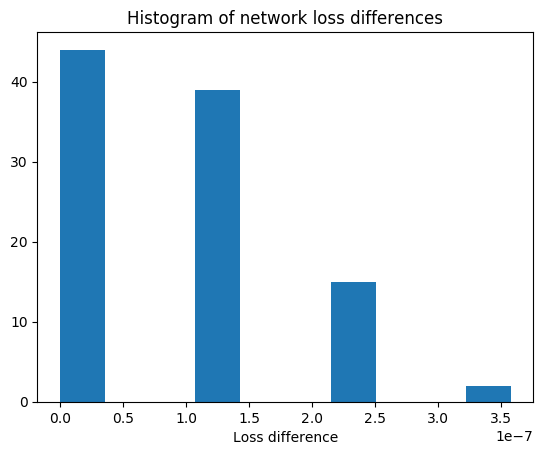

In [28]:
# Absolute differences of the loss values of the original and the modified nets
plt.rcParams.update(plt.rcParamsDefault)
net_diff = np.absolute(new_data_loss - orig_data_loss)
plt.hist(net_diff);
plt.xlabel('Loss difference')
plt.title('Histogram of network loss differences')

print 'Machine epsilon for float:'
print(np.finfo(np.float32).eps)


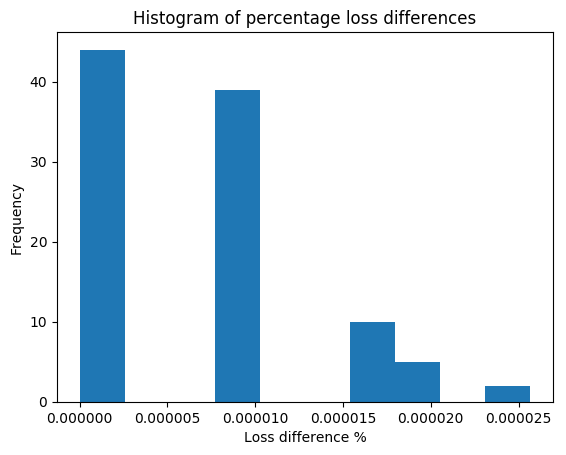

In [27]:
# Percentage difference between the network losses
plt.rcParams.update(plt.rcParamsDefault)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100
plt.hist(net_diff_percent);
plt.title('Histogram of percentage loss differences')
plt.ylabel('Frequency')
plt.xlabel('Loss difference %')


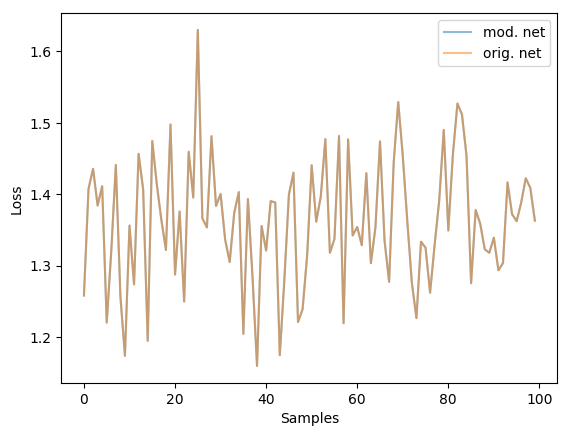

In [31]:
# Sanity check: plot the two network data losses at 100 points. 
# There should be near-perfect overlap!
plt.rcParams.update(plt.rcParamsDefault)
plt.plot(range(len(new_data_loss)), new_data_loss, alpha=0.5, label='mod. net')
plt.plot(range(len(orig_data_loss)), orig_data_loss, alpha=0.5, label='orig. net')
plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()

In [32]:
# Evaluate the performance of reduced network
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Modified network test accuracy: %.2f' % abl_accu

abl_accu = accuracy_on_dataset(net, trainloader, True)
print 'Modified network train accuracy: %.2f' % abl_accu

Modified network test accuracy: 53.00
Modified network train accuracy: 56.00


### Replace near-duplicate normalized filters

Following unit-normalization of the filters, we go through the groups of near-identical (in cosine sense) filters and replace all filters in a group with the within-group mean filter. The connections to the next layer (fc2) are suitably modified as fc1 filters are removed. This should also not result in any large changes to the network function, depending upon _how close the within-group filter vectors were_ and the _conditioning of weight matrices_ that will govern the amplification or attenuation of signal propagation through the subsequent layers of the network.


#### Condition for modifying filter values

For our two-layer fully-connected network, let the output of the second layer (fc2) be

$$ \mathbf{z} =  V \mathbf{y}  =  V \phi( W\mathbf{x} + \mathbf{b} ) $$

Replacing all the near-duplicate filters with their means in **W** amounts to a small perturbation in the input, **y**, to the subsequent layer. We can then focus only on the linear system **z = Vy**. A small perturbation in **y** will not end up being magnified downstream in the network if the **V** matrix does not amplify its input signal by much. 

This possible signal amplification of the output **z**, which can be characteriszed by its 2-norm, is upper-bounded by the _maximum singular value_ of the weight matrix **V**:

$$ ||\mathbf{z}|| \le \sigma_{max} ||\mathbf{y}||  $$

The two non-linearities used in this network, ReLU and the sigmoid, are both norm-reducing operations - the ReLU gets rid of negatives and is linear otherwise, thus this cannot amplify the input. The sigmoid is a squashing function and will not amplify its inputs.



In [70]:
import scipy

net.cpu()
w1 = net.fc1.weight.data
w1 = w1.numpy()
w2 = net.fc2.weight.data
w2 = w2.numpy()
sigma_w1 = scipy.linalg.svdvals(w1)
sigma_w2 = scipy.linalg.svdvals(w2)

print 'Max singular value of fc2: %f' % sigma_w2[0]

Max singular value of fc2: 0.553404


#### Make similar filter pairs identical

As a sanity check, we take the top 50 similar filter pairs and make the two filters exactly equal.

In [34]:
# Sanity-check: get 50 pairs of fc1 filters and merge them
MAX_PAIRS = 50
net.cpu()
fc1Params = list(net.fc1.parameters())
w = fc1Params[0].data.numpy()

similMat, _ = get_layer_cosine_similarity(net, 'fc1.weight')
f, pairList = vis_closest_filter_pairs(w, similMat, MAX_PAIRS); 
plt.close()

print 'Similar filter pair: '
print w[pairList[0][1]]
print w[pairList[0][2]]

# make pairs identical
for j in range(MAX_PAIRS):
    listItem = pairList[j] # (similarity, rowId, colId)
    w[listItem[1]] = w[listItem[2]]
    
# check values again
print 'After duplicating pairs: '
print w[pairList[0][1]]
print w[pairList[0][2]]
    

Similar filter pair: 
[-0.05197979 -0.05227507 -0.04676607 ..., -0.01355342 -0.01328033
 -0.00744224]
[-0.05232007 -0.0526167  -0.04717456 ..., -0.01337882 -0.0131278
 -0.00742662]
After duplicating pairs: 
[-0.05232007 -0.0526167  -0.04717456 ..., -0.01337882 -0.0131278
 -0.00742662]
[-0.05232007 -0.0526167  -0.04717456 ..., -0.01337882 -0.0131278
 -0.00742662]


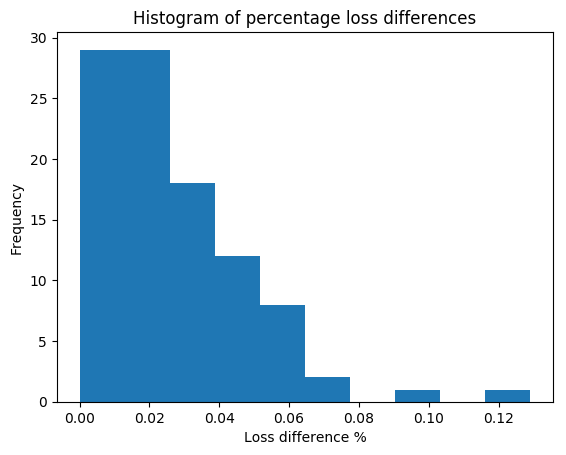

In [35]:
# Network loss value changes
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100
plt.hist(net_diff_percent);
plt.title('Histogram of percentage loss differences')
plt.ylabel('Frequency')
plt.xlabel('Loss difference %')

#### Reduce fc1 filter groups

In this simple ablation scheme, we replace each group of similar filters by its mean filter. We do the same naive averaging for the biases as well. The size of the first layer is reduced from 500 to 399 units, due to the 399 groups of similar filters that were formed in the connected components step.

In [36]:
# Sanity checks about using nn.Parameter()
net.fc1.weight = nn.Parameter(net.fc1.weight.data)
net.fc1.bias = nn.Parameter(net.fc1.bias.data)
net.fc2.weight = nn.Parameter(net.fc2.weight.data)

# Check the network accuracy
net.eval()
net.cuda()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Network accuracy: %.2f%%' % abl_accu

Network accuracy: 53.00%


In [37]:
# transfer network to CPU if on GPU
if next(net.parameters()).is_cuda:
    net.cpu()


In [38]:
# FC1 reduction

assert(not next(net.parameters()).is_cuda) # everything is on CPU

# Reduce FC-2 layer weights - sum
fc2_groups = [net.fc2.weight[:,x] for x in cc_list]
fc2_reduced = [x.sum(dim=1) for x in fc2_groups]
fc2_filter_cat = torch.stack(fc2_reduced, dim=0)
fc2_filter_cat = fc2_filter_cat.t()

# Reduce FC-1 layer biases - mean
fc1_bias_groups = [net.fc1.bias[torch.LongTensor(x)] for x in cc_list]
fc1_bias_reduced = [x.mean() for x in fc1_bias_groups]
fc1_bias_cat = torch.cat(fc1_bias_reduced, dim=0)
fc1_bias_cat.squeeze_()

# Reduce FC-1 layer filters - mean
fc1_filter_groups = [net.fc1.weight[torch.LongTensor(x)] for x in cc_list]
fc1_filter_reduced = [x.mean(dim=0) for x in fc1_filter_groups]
fc1_filter_cat = torch.stack(fc1_filter_reduced, dim=0)

# Wrap by nn.Parameter
net.fc1.weight = nn.Parameter(fc1_filter_cat.data)
net.fc1.bias = nn.Parameter(fc1_bias_cat.data)
net.fc2.weight = nn.Parameter(fc2_filter_cat.data)


In [45]:
# Evaluate reduced network's accuracy
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % abl_accu

Reduced network accuracy: 53.00 %


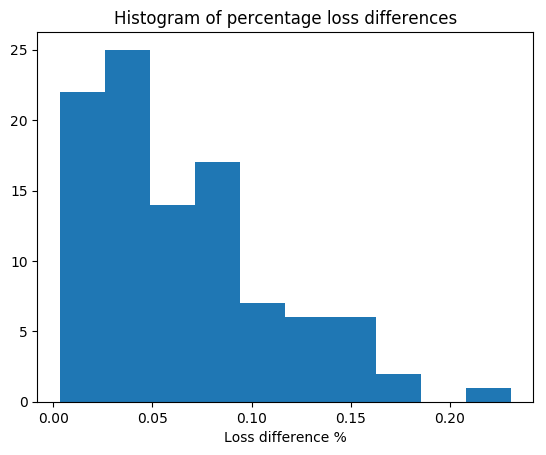

In [50]:
# Network loss value changes
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100
plt.hist(net_diff_percent);
plt.title('Histogram of percentage loss differences')
# plt.ylabel('Frequency')
plt.yticks = []
plt.xlabel('Loss difference %')

In [43]:
net.fc1.weight

Parameter containing:
 4.2313e-03  1.4113e-02  9.1959e-03  ...  -4.1707e-03 -2.9890e-03 -5.8808e-03
 1.8565e-02  1.2122e-02  1.0683e-02  ...  -1.6856e-02 -2.4578e-02 -2.1408e-02
-7.8948e-03 -1.1359e-02 -1.6750e-02  ...  -6.0548e-03 -1.3147e-03  1.0101e-05
                ...                   ⋱                   ...                
-1.8862e-02 -1.9985e-02 -9.4565e-03  ...  -1.0967e-02 -6.3406e-03 -3.7024e-03
 1.7638e-02  1.2538e-02  6.7452e-03  ...   1.8599e-02  2.2717e-02  2.1595e-02
-4.8280e-03 -1.7459e-02 -1.0852e-02  ...  -9.8067e-03 -1.2381e-02 -2.2174e-02
[torch.cuda.FloatTensor of size 399x3072 (GPU 0)]

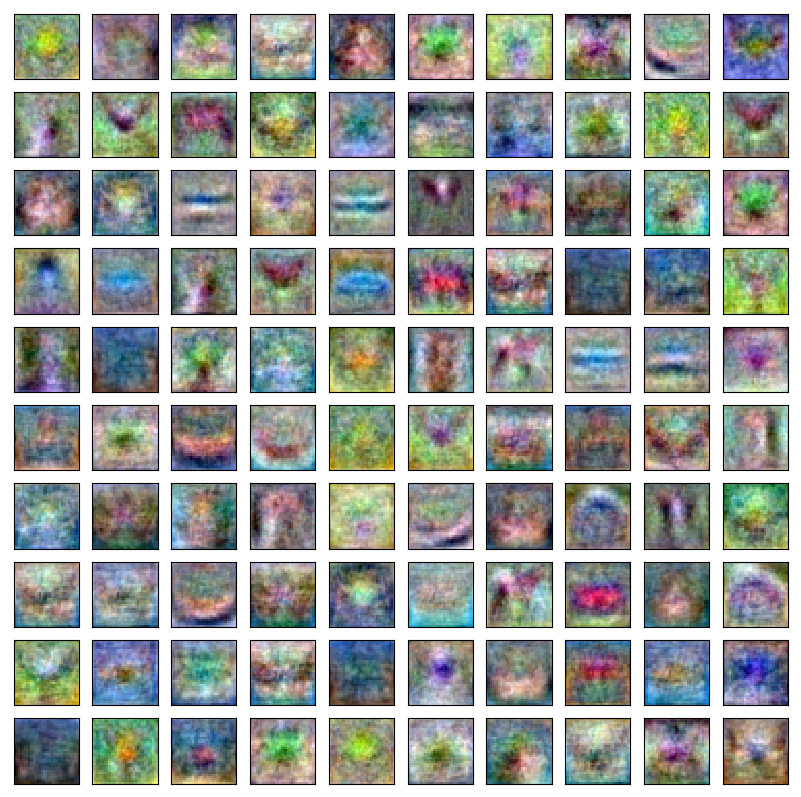

In [51]:
w1a = fc1_filter_cat.cpu()
f = vis_linear_weights(w1a.data.numpy())

### Ablation 2: reduce to unique biases

Given that biases are significant (affect accuracy by 1%), we reduce only those filters in a filter group (connected-component) that have identical bias terms. While this would result in less reduction in parameters, we should also have near equivalence of the network output before and after the ablation. 

In [71]:
# Histogram of bias values
import itertools
fc1_biases = net.fc1.bias.data.cpu()
fc1_biases = fc1_biases.numpy()
bias_val = [fc1_biases[x] for x in cc_list]

bias_vals_flat = list(itertools.chain.from_iterable(bias_val))
plt.hist(bias_vals_flat)
plt.grid()
plt.title('Histogram of bias values')


IndexError: index 402 is out of bounds for axis 1 with size 399

In [43]:
# Re-load the original network
net = MLP(input_dim=3072, fc1_dim=500, fc2_dim=100)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

In [225]:
# Get the unique bias terms in each group of similar filters

bias_unique, bias_unique_idx = zip(*( np.unique(x,  return_index=True)\
                           for x in bias_val))
bias_unique_idx


(array([ 4,  0, 11,  2, 17, 10,  1, 14,  5,  3,  8,  7]),
 array([1, 0]),
 array([1, 0]),
 array([0]),
 array([0]),
 array([1, 0]),
 array([0]),
 array([0]),
 array([0]),
 array([2, 0, 1, 3]),
 array([0]),
 array([0]),
 array([0]),
 array([2, 0, 1, 3]),
 array([2, 1, 5, 0]),
 array([0]),
 array([0]),
 array([3, 1, 0, 2]),
 array([2, 5, 6, 0, 1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0, 1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([2, 0, 1, 4]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0, 1]),
 array([0, 1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0, 1]),
 array

In [226]:
bias_val

[array([ 0.00769131,  0.01790267,  0.01179683,  0.03013024,  0.        ,
         0.02513328,  0.        ,  0.07092207,  0.04265293,  0.        ,
         0.01760621,  0.00885033,  0.        ,  0.        ,  0.02421225,
         0.        ,  0.        ,  0.01596326,  0.        ,  0.        ,  0.        ], dtype=float32),
 array([ 0.00802891,  0.        ], dtype=float32),
 array([ 0.00834615,  0.        ,  0.        ], dtype=float32),
 array([ 0.0087124], dtype=float32),
 array([ 0.00900509], dtype=float32),
 array([ 0.00977978,  0.        ,  0.        ,  0.        ], dtype=float32),
 array([ 0.01108932], dtype=float32),
 array([ 0.01147795], dtype=float32),
 array([ 0.01225822], dtype=float32),
 array([ 0.01464979,  0.01784183,  0.        ,  0.03079301], dtype=float32),
 array([ 0.01694], dtype=float32),
 array([ 0.01943754], dtype=float32),
 array([ 0.02052768], dtype=float32),
 array([ 0.02085854,  0.02107028,  0.        ,  0.02395073], dtype=float32),
 array([ 0.02609462,  0.        

In [227]:
# Get the filters in each filter-group (cc) corresponding to unique biases
import itertools

net.cpu()

# form filter groups at fc1
fc1_filter_groups = [net.fc1.weight[torch.LongTensor(x)]\
                     for x in cc_list]

# select the filters, in each group, with unique biases
fc1_filter_reduced = [f[torch.LongTensor(b)] \
                      for f,b in itertools.izip(\
                            fc1_filter_groups, bias_unique_idx)]
fc1_filter_cat = torch.cat(\
                fc1_filter_reduced,\
                dim=0)

In [228]:
# Get the unique fc1 biases

# form biases corresponding to filter groups at fc1
fc1_bias_groups = [net.fc1.bias[torch.LongTensor(x)]\
                     for x in cc_list]

# select, in each group, the unique biases (using pre-computed "unique-bias" indices)
fc1_bias_reduced = [bias[torch.LongTensor(bid)] \
                      for bias,bid in itertools.izip(\
                            fc1_bias_groups, bias_unique_idx)]

fc1_bias_cat = torch.cat(\
                fc1_bias_reduced,\
                dim=0)


In [229]:
# Modify the fc2 weights to correspond to the changed fc1 weights and biases
net.cpu()

# Reduce FC-2 layer weights(select from the unique ones)
fc2_groups = [net.fc2.weight[:,x] for x in cc_list]

fc2_reduced = [f[:,torch.LongTensor(i)] \
                      for f,i in itertools.izip(\
                            fc2_groups, bias_unique_idx)]

fc2_filter_cat = torch.cat(tuple(fc2_reduced),1)


In [230]:
# Wrap by nn.Parameter
net.fc1.weight = nn.Parameter(fc1_filter_cat.data)
net.fc1.bias = nn.Parameter(fc1_bias_cat.data)
net.fc2.weight = nn.Parameter(fc2_filter_cat.data)

In [231]:
# Evaluate reduced network
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Ablated network accuracy: %.2f' % abl_accu

Ablated network accuracy: 52.00


In [232]:
# sizes after unique-bias reduction
print 'Bias size:'
print fc1_bias_cat.size()
print 'Filter size:'
print fc1_filter_cat.size()



Bias size:
torch.Size([456])
Filter size:
torch.Size([456, 3072])


*There has been no reduction in number of parameters by reducing filter groups on the basis of unique biases!*

All biases are unique within a group, even if all the filters in a group are similar!

## Ablation 3: discard small biases

Compare the bias values with the expected value of activations over a data sample. If a bias value is very small compared to the activation, then that bias will not shift the result by much. If we drop all such bias terms, how much accuracy do we lose?


In [211]:
# Re-load the original network
net = MLP(input_dim=3072, fc1_dim=500, fc2_dim=100)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

# Load pre-computed fc1 features (from feature_scale.ipynb)
feat = np.load(os.path.join('./data', expName, 'feat-fc1.npy'))
mean_feat = feat.mean(0)
del feat

# Re-compute fc1 biases
fc1_biases = net.fc1.bias.data.cpu()
fc1_biases = fc1_biases.numpy()

In [212]:
# Mean activation values for one filter group
print 'Mean activations:'
print mean_feat[cc_list[0]]
print 'Biases:'
print fc1_biases[cc_list[0]]

Mean activations:
[ 0.12065136  0.45071661  0.08296971  0.12796277  0.11712002  0.05799604
  0.14168932  0.076001    0.05549251  0.18986091  0.17892522  0.17326644
  0.17918296  0.09639844  0.07890487  0.05135545  0.04605578  0.13490535
  0.0692167   0.11791885  0.08347097]
Biases:
[ 0.01790267  0.06339222  0.01225822  0.01943754  0.01694     0.0087124
  0.02052768  0.00977978  0.00900509  0.02609462  0.0275471   0.02839933
  0.02669318  0.01464979  0.01108932  0.00769131  0.00802891  0.02085854
  0.00834615  0.01784183  0.01147795]


In [213]:
# log of ratio of absolute values of mean feature activation and bias
log_ratio = np.log10( np.absolute(\
                      np.divide(mean_feat, fc1_biases) ) )

/home/arunirc/pytorch-cifar/lib/python2.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """


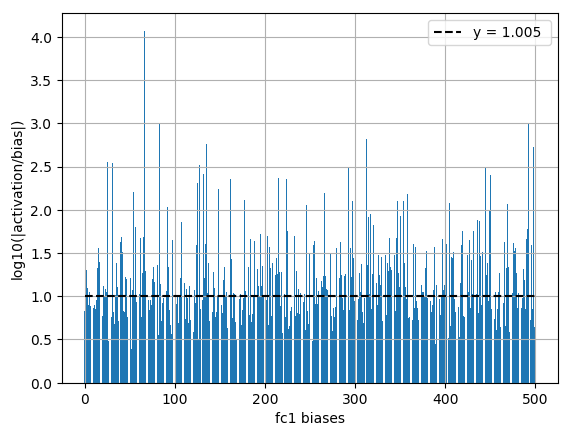

In [241]:
plt.bar(range(len(log_ratio)), log_ratio)
plt.xlabel('fc1 biases')
plt.ylabel('log10(|activation/bias|)')
plt.grid()
plt.hold()
plt.hlines(1.005, 0, 500, linestyles='dashed', label='y = 1.005 ')
plt.legend()

In [214]:
# Set all filters at log-ratio > 1.005 to zero
net.cpu()
sel = log_ratio > 1.005
print 'Log-ratio > 1.005: %d/%d' % (np.sum(sel), sel.size )
sel = np.flatnonzero(sel)
net.fc1.bias.data[torch.LongTensor(sel)] = 0

# Evaluate ablated-bias network
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Ablated network accuracy: %.2f' % abl_accu

Log-ratio > 1.005: 302/500
Ablated network accuracy: 53.00


In [191]:
# Set all filters at log-ratio > 1 to zero
net.cpu()
sel = log_ratio > 1.0
print 'Log-ratio > 1.0: %d/%d' % (np.sum(sel), sel.size )
sel = np.flatnonzero(sel)
net.fc1.bias.data[torch.LongTensor(sel)] = 0

# Evaluate ablated-bias network
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Ablated network accuracy: %.2f' % abl_accu

Log-ratio > 1.0: 305/500
Ablated network accuracy: 52.00


Thresholding the log-ratio of activations to bias magnitudes at **1.005** gives us unchanged performance at 53%. 

In [233]:
# Re-load the original network
net = MLP(input_dim=3072, fc1_dim=500, fc2_dim=100)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
net.cpu()

# Set negligible biases to zero
sel = log_ratio > 1.005
print 'Log-ratio > 1.005: %d/%d' % (np.sum(sel), sel.size )
sel = np.flatnonzero(sel)
net.fc1.bias.data[torch.LongTensor(sel)] = 0

# Evaluate ablated-bias network
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Ablated network accuracy: %.2f' % abl_accu

Log-ratio > 1.005: 302/500
Ablated network accuracy: 53.00


### Ablation 4 - reduce filters and biases with small relative difference

* in each Similar Filter group
    * compare the absolute difference between biases scaled by the mean activation value
    * mean-reduce the filters corresponding to similar biases
    * sum-reduce the connections (fc2 weights) corrresponding to reduced fc1 parameters


In [74]:
# Re-load the original network
net = MLP(input_dim=3072, fc1_dim=500, fc2_dim=100)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

# Load pre-computed fc1 features (from feature_scale.ipynb)
feat = np.load(os.path.join('./data', expName, 'feat-fc1.npy'))
mean_feat = feat.mean(0) # mean value for each feature
del feat

# Re-compute fc1 biases
fc1_biases = net.fc1.bias.data.cpu()
fc1_biases = fc1_biases.numpy()

# Compute norms of the fc1 filters
fc1_w_norm = np.asarray([np.linalg.norm(w.numpy()) for w in net.fc1.weight.data])
print len(fc1_w_norm)
type(fc1_w_norm)

500


numpy.ndarray

Mean activations:
[ 0.12065136  0.45071661  0.08296971  0.12796277  0.11712002  0.05799604
  0.14168932  0.076001    0.05549251  0.18986091  0.17892522  0.17326644
  0.17918296  0.09639844  0.07890487  0.05135545  0.04605578  0.13490535
  0.0692167   0.11791885  0.08347097]
Biases:
[ 0.01790267  0.06339222  0.01225822  0.01943754  0.01694     0.0087124
  0.02052768  0.00977978  0.00900509  0.02609462  0.0275471   0.02839933
  0.02669318  0.01464979  0.01108932  0.00769131  0.00802891  0.02085854
  0.00834615  0.01784183  0.01147795]
Scaled biases:
[ 0.14838347  0.14064762  0.14774331  0.15189993  0.14463791  0.15022406
  0.14487813  0.12867966  0.16227573  0.13744071  0.15395872  0.16390553
  0.14897162  0.15197122  0.14054044  0.14976615  0.17433012  0.1546161
  0.12057997  0.151306    0.1375083 ]
Filter norms:
[ 0.04557916  0.18611306  0.03272353  0.04891662  0.04461047  0.02315434
  0.04958731  0.02920825  0.02391315  0.06488324  0.06625801  0.07500186
  0.06756055  0.0349259   0.02

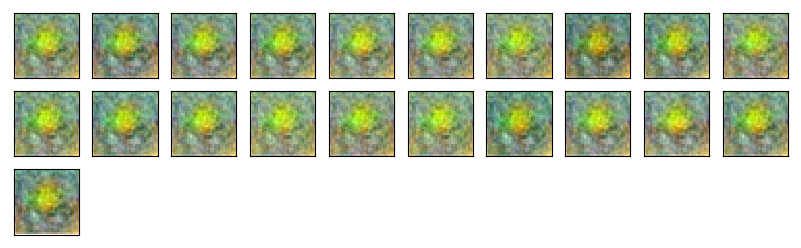

In [92]:
# Show values for one filter group
print 'Mean activations:'
print mean_feat[cc_list[0]]

print 'Biases:'
print fc1_biases[cc_list[0]]
scaled_biases = np.divide(fc1_biases[cc_list[0]], mean_feat[cc_list[0]])

print 'Scaled biases:'
print scaled_biases

# # scaled pairwise differences
# pair_bias = [x for x in itertools.combinations(scaled_biases, 2)]
# pair_diff = [np.absolute(x[0]-x[1]) for x in itertools.combinations(scaled_biases, 2)]
# print 'Bias pair diff:'
# print pair_diff

print 'Filter norms:'
print fc1_w_norm[cc_list[0]]

print 'Filter visualizations:'
f = vis_linear_weights(fc1_weights[cc_list[0]])

In [17]:
# Get the loss at each data point for the unchanged network
orig_data_loss = get_dataset_loss(net, trainloader)
np.mean(orig_data_loss)

1.2779857

In [88]:
import itertools
# from scipy import spatial

net.cpu()

BIAS_THRESH = 0.01
pair_diff_list = []
group_pair_diff = []

for group_idx in cc_list:
    
    # get the biases within a filter group
    group_biases = net.fc1.bias[torch.LongTensor(group_idx)]
    group_biases = group_biases.data.cpu()
    group_biases = group_biases.numpy()
    print 'biases:'
    print group_biases
    
    # get mean activations within a filter group
    group_activation = mean_feat[group_idx]
    print 'mean activation:'
    print group_activation
    
    # scaled each bias by the mean activation
    scaled_biases = np.divide(group_biases, group_activation)
    print 'scaled biases:'
    print scaled_biases   
    
    # scaled pairwise differences
    pair_bias = [x for x in itertools.combinations(scaled_biases, 2)]
    pair_diff = [np.absolute(x[0]-x[1]) for x in itertools.combinations(scaled_biases, 2)]
    print 'pair diff:'
    print pair_diff
    
    # pairwise indices
    
    
    # print pair_bias[0]
    pair_diff_list.extend(pair_diff)
    group_pair_diff.append(pair_diff)
    
    # break # debug

biases:
[ 0.01790267  0.06339222  0.01225822  0.01943754  0.01694     0.0087124
  0.02052768  0.00977978  0.00900509  0.02609462  0.0275471   0.02839933
  0.02669318  0.01464979  0.01108932  0.00769131  0.00802891  0.02085854
  0.00834615  0.01784183  0.01147795]
mean activation:
[ 0.12065136  0.45071661  0.08296971  0.12796277  0.11712002  0.05799604
  0.14168932  0.076001    0.05549251  0.18986091  0.17892522  0.17326644
  0.17918296  0.09639844  0.07890487  0.05135545  0.04605578  0.13490535
  0.0692167   0.11791885  0.08347097]
scaled biases:
[ 0.14838347  0.14064762  0.14774331  0.15189993  0.14463791  0.15022406
  0.14487813  0.12867966  0.16227573  0.13744071  0.15395872  0.16390553
  0.14897162  0.15197122  0.14054044  0.14976615  0.17433012  0.1546161
  0.12057997  0.151306    0.1375083 ]
pair diff:
[0.0077358484, 0.00064015388, 0.0035164654, 0.0037455559, 0.0018405914, 0.0035053343, 0.019703805, 0.013892263, 0.010942757, 0.0055752546, 0.015522063, 0.00058814883, 0.0035877526,

biases:
[-0.00261002]
mean activation:
[ 0.28271878]
scaled biases:
[-0.00923186]
pair diff:
[]
biases:
[ 0.00174038  0.00643902]
mean activation:
[ 0.03837603  0.11036254]
scaled biases:
[ 0.04535077  0.05834421]
pair diff:
[0.012993444]
biases:
[-0.08702511]
mean activation:
[ 0.40987876]
scaled biases:
[-0.21231917]
pair diff:
[]
biases:
[ 0.01618143  0.03488086]
mean activation:
[ 0.05864802  0.11743311]
scaled biases:
[ 0.27590752  0.29702747]
pair diff:
[0.021119952]
biases:
[ 0.00227395]
mean activation:
[ 0.10122908]
scaled biases:
[ 0.02246339]
pair diff:
[]
biases:
[ 0.00283692]
mean activation:
[ 0.12973192]
scaled biases:
[ 0.02186755]
pair diff:
[]
biases:
[ 0.03938906]
mean activation:
[ 0.2163735]
scaled biases:
[ 0.18204199]
pair diff:
[]
biases:
[ 0.01142676]
mean activation:
[ 0.18270455]
scaled biases:
[ 0.06254231]
pair diff:
[]
biases:
[ 0.01730013]
mean activation:
[ 0.20035686]
scaled biases:
[ 0.0863466]
pair diff:
[]
biases:
[ 0.00921285]
mean activation:
[ 0.0

biases:
[ 0.01526611]
mean activation:
[ 0.09603526]
scaled biases:
[ 0.15896362]
pair diff:
[]
biases:
[ 0.04124468]
mean activation:
[ 0.410981]
scaled biases:
[ 0.10035665]
pair diff:
[]
biases:
[ 0.00851464]
mean activation:
[ 0.3664155]
scaled biases:
[ 0.02323765]
pair diff:
[]
biases:
[ 0.02185548]
mean activation:
[ 0.22526662]
scaled biases:
[ 0.09702052]
pair diff:
[]
biases:
[ 0.03045806]
mean activation:
[ 0.28899056]
scaled biases:
[ 0.10539465]
pair diff:
[]
biases:
[ 0.00830902]
mean activation:
[ 0.06249183]
scaled biases:
[ 0.13296166]
pair diff:
[]
biases:
[ 0.02149353]
mean activation:
[ 0.27865016]
scaled biases:
[ 0.07713445]
pair diff:
[]
biases:
[ 0.01198594]
mean activation:
[ 0.12066886]
scaled biases:
[ 0.09932919]
pair diff:
[]
biases:
[-0.00421966]
mean activation:
[ 0.22013304]
scaled biases:
[-0.01916869]
pair diff:
[]
biases:
[ 0.00769636]
mean activation:
[ 0.10218868]
scaled biases:
[ 0.07531524]
pair diff:
[]
biases:
[ 0.01441611]
mean activation:
[ 0.

pair diff:
[]
biases:
[-0.01008812]
mean activation:
[ 0.27802667]
scaled biases:
[-0.03628471]
pair diff:
[]
biases:
[ 0.00670609]
mean activation:
[ 0.05855247]
scaled biases:
[ 0.11453128]
pair diff:
[]
biases:
[ 0.0012546]
mean activation:
[ 0.26514325]
scaled biases:
[ 0.00473178]
pair diff:
[]
biases:
[ 0.00212632]
mean activation:
[ 0.01895037]
scaled biases:
[ 0.11220488]
pair diff:
[]
biases:
[-0.02765372]
mean activation:
[ 0.14721015]
scaled biases:
[-0.18785197]
pair diff:
[]
biases:
[ 0.04915974]
mean activation:
[ 0.45572555]
scaled biases:
[ 0.10787138]
pair diff:
[]
biases:
[ 0.00293367]
mean activation:
[ 0.05445484]
scaled biases:
[ 0.05387348]
pair diff:
[]
biases:
[ 0.04283476]
mean activation:
[ 0.21179879]
scaled biases:
[ 0.2022427]
pair diff:
[]
biases:
[-0.01441665]
mean activation:
[ 0.15083475]
scaled biases:
[-0.09557907]
pair diff:
[]
biases:
[ 0.01129386  0.01357236]
mean activation:
[ 0.05694385  0.06463755]
scaled biases:
[ 0.19833323  0.20997635]
pair d

[]
biases:
[ 0.00822463]
mean activation:
[ 0.32597181]
scaled biases:
[ 0.02523111]
pair diff:
[]
biases:
[ 0.02924261]
mean activation:
[ 0.2223492]
scaled biases:
[ 0.13151661]
pair diff:
[]
biases:
[ 0.03079301]
mean activation:
[ 0.10382806]
scaled biases:
[ 0.29657695]
pair diff:
[]
biases:
[-0.0225834]
mean activation:
[ 0.31738356]
scaled biases:
[-0.07115491]
pair diff:
[]
biases:
[-0.00590862 -0.00491938]
mean activation:
[ 0.23096141  0.16047572]
scaled biases:
[-0.0255827  -0.03065495]
pair diff:
[0.0050722528]
biases:
[ 0.00052257]
mean activation:
[ 0.02968385]
scaled biases:
[ 0.0176046]
pair diff:
[]
biases:
[ 0.05192913]
mean activation:
[ 0.30465287]
scaled biases:
[ 0.17045346]
pair diff:
[]
biases:
[-0.02198277]
mean activation:
[ 0.12532423]
scaled biases:
[-0.17540722]
pair diff:
[]
biases:
[ 0.0021101]
mean activation:
[ 0.13233586]
scaled biases:
[ 0.01594504]
pair diff:
[]
biases:
[ 0.01332345]
mean activation:
[ 0.22262445]
scaled biases:
[ 0.05984719]
pair di

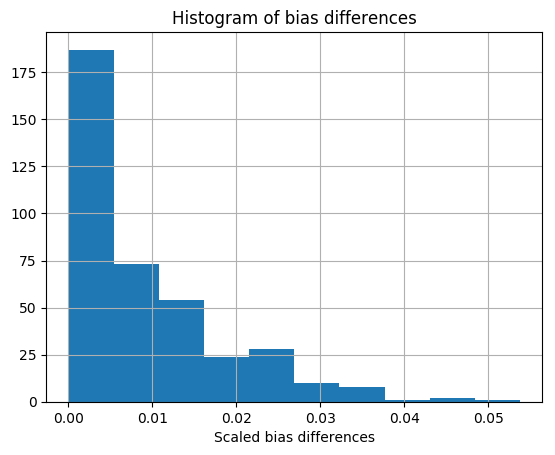

In [87]:
plt.hist(pair_diff_list);
plt.title('Histogram of bias differences')
plt.xlabel('Scaled bias differences')
plt.grid()

In [94]:
# Merge similar filters and biases

import itertools
# from scipy import spatial

net.cpu()

BIAS_THRESH = 0.01
pair_diff_list = []
group_pair_diff = []

for group_idx in cc_list:
    
    # get the biases within a filter group
    group_biases = net.fc1.bias[torch.LongTensor(group_idx)]
    group_biases = group_biases.data.cpu()
    group_biases = group_biases.numpy()
    
    # get mean activations within a filter group
    group_activation = mean_feat[group_idx]
    
    # scaled each bias by the mean activation
    scaled_biases = np.divide(group_biases, group_activation)
    
    # pairwise differences
    pair_diff = [np.absolute(x[0]-x[1]) for x in itertools.combinations(scaled_biases, 2)]
    
    # pairwise indices
    pair_indices = [x for x in itertools.combinations(range(len(scaled_biases)), 2)]
    
    for i, pair_id in enumerate(pair_indices,0):
        if pair_diff < BIAS_THRESH:
            
        
        
        
        
        
    
    break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
